## Problem Statement:
### A dataset is provided on breast cell parameters measured on patients with the cell type as being malignant or benign. The objective of this work is to use the features provided and build a product that can help determine if a breast cell is harmful or not given the experimental features. Final results will help doctors make more comprehensive decisions on next steps with their patients' diagnosis.

## Approach:
### Build a classification model that can automatically label the biopsy result as bengin or malignant based on the provided features. Simplify the model using the top features and compare the models on their performance metrics. 
### In this case, recall has been selected as the point performance metric, since having minimal false negatives is critical for cancer detection.

## Result:


#### It has been proved that classification can be performed using the top 5 important features, without major performance loss. That resulted in 45% reduction in testing requirements.

#### Housekeeping

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score, precision_score, f1_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.feature_selection import RFE
%matplotlib inline

#### Data clean-up

In [ ]:
# load the dataset
data = pd.read_csv('breast-cancer-wisconsin.txt', index_col = 0, header = 0)

# Update the dataset type to numeric
data = data.apply(pd.to_numeric, errors = "coerce", axis = 1)

# Get the NaN indices
nan_idx = np.unique(np.where(np.isnan(data))[0])

nan_ids = data['ID'][nan_idx]
# Get the length of rows with NaN values in them
print("length of rows containing NaNs {}".format(len(nan_ids)))

# Drop null values
data.dropna(inplace = True, how = 'any', axis = 0)

# Make sure there are only two labels in the class (2,4)
data = data[data['Class'].isin([2,4])]

# Change label 2 to 0 and label 4 to 1
data.loc[data['Class'] == 2, 'Class'] = 0
data.loc[data['Class'] == 4, 'Class'] = 1

# Drop duplicates in the dataset
data.drop_duplicates(inplace = True)

# Print the length of dataset for class 0 and 1
print("length of class 0: {}, length of class 1: {}".format(len(data[data['Class'] == 0]), len(data[data['Class'] == 1])))

#### Data visualization

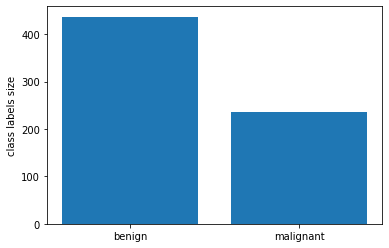

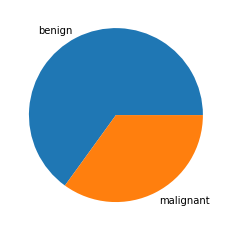

In [15]:
class_0 = data[data['Class'] == 0]
class_1 = data[data['Class'] == 1]
plt.bar(x = [1,2], height = [len(class_0), len(class_1)], tick_label = ['benign', 'malignant'])
plt.ylabel('class labels size')
plt.show()

plt.pie([len(class_0), len(class_1)], labels = ['benign', 'malignant'])
plt.show()

#### Feature exploration
##### In order to understand which features are driving the malignancy, let's calculate Pearson correlation of each feature.

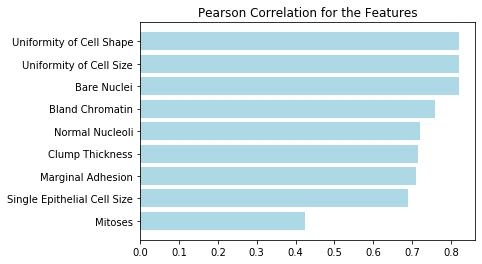

In [32]:
# Comput correlation
class_corr = data.corr(method = 'pearson')['Class']

# Drop columns ID and Class
class_corr = class_corr.drop(index = ['ID', 'Class'])

# Get class_corr indices
class_corr_idx = np.argsort(np.abs(class_corr))

# Plot feature correlation
plt.barh(range(len(class_corr_idx)), class_corr[class_corr_idx], color = 'lightblue', align = 'center')
plt.yticks(range(len(class_corr_idx)), [class_corr.index[i] for i in class_corr_idx])
plt.title("Pearson Correlation for the Features")
plt.show()

In [30]:
class_corr_idx

Clump Thickness                8
Uniformity of Cell Size        4
Uniformity of Cell Shape       3
Marginal Adhesion              0
Single Epithelial Cell Size    7
Bare Nuclei                    6
Bland Chromatin                5
Normal Nucleoli                1
Mitoses                        2
Name: Class, dtype: int64

#### Model fitting
##### Building a basic model first

In [57]:
input_cols = ['Clump Thickness', 'Uniformity of Cell Size',
       'Uniformity of Cell Shape', 'Marginal Adhesion',
       'Single Epithelial Cell Size', 'Bare Nuclei', 'Bland Chromatin',
       'Normal Nucleoli', 'Mitoses']

X = data[input_cols]
y = data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True, stratify = y, random_state = 42)

# Build a logistic regression model
lg_reg = LogisticRegression(penalty = 'none', solver = 'lbfgs')
metrics = ['f1', 'precision', 'recall', 'roc_auc']
splitter = StratifiedKFold(n_splits = 5, shuffle = True, random_state = 42)
cv_scores = cross_validate(lg_reg, X_train, y_train, cv = splitter, scoring = metrics)

score_means = {k: np.round(np.mean(v),3) for k,v in cv_scores.items()}
score = {k:v for k,v in cv_scores.items()}
scores = pd.DataFrame(score).round(3)

print("Mean cross-validation scores:", score_means)

scores

Mean cross-validation scores: {'fit_time': 0.014, 'score_time': 0.01, 'test_f1': 0.955, 'test_precision': 0.969, 'test_recall': 0.942, 'test_roc_auc': 0.994}


,fit_time,score_time,test_f1,test_precision,test_recall,test_roc_auc
0,0.015,0.012,0.923,0.900,0.947,0.978
1,0.018,0.008,0.959,1.000,0.921,0.999
2,0.012,0.008,0.960,0.973,0.947,0.999
3,0.016,0.008,0.959,0.972,0.946,0.997
4,0.012,0.012,0.972,1.000,0.946,1.000


In [65]:
# Validation
lg_reg.fit(X_train, y_train)
y_predict = lg_reg.predict(X_test)

full_model_scores = pd.DataFrame({'Full recall scores': [recall_score(y_predict, y_test)], 
                                'Full precision scores': [precision_score(y_predict, y_test)],
                                'Full f1 scores': [f1_score(y_predict, y_test)]})

full_model_scores

,Full recall scores,Full precision scores,Full f1 scores
0,0.886792,1.0,0.94


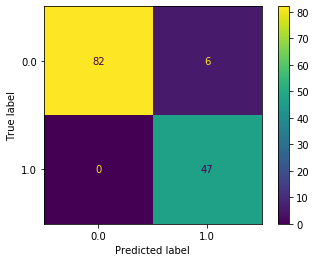

In [67]:
plot_confusion_matrix(lg_reg, X_test, y_test)

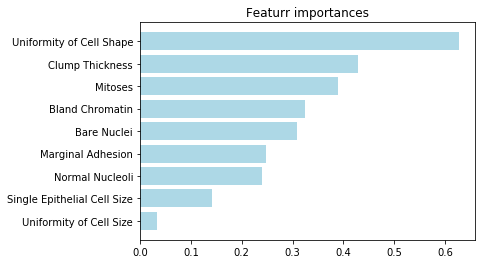

In [76]:
params = pd.Series(lg_reg.coef_[0], index = X.columns)
params = params.sort_values()

features = pd.DataFrame({'effect': params.round(3)})

plt.barh(range(len(features.index)), features['effect'], color = 'lightblue', align = 'center')
plt.yticks(range(len(features)), features.index)
plt.title("Featurr importances")
plt.show()






#### Zero false negatives!

In [ ]:
# Get important features
importances = lg_reg.feature_importances_
imp_indices = np.argsort(importances)
plt.title("Feature Importances")
plt.barh(range(len(imp_indices)), importances[imp_indices], align = 'center')
plt.yticks(range(len(imp_indices)), [input_cols[i] for i in imp_indices])
plt.xlabel('importance')
plt.show()

#### Feature selection

In [82]:
#Recursive feature selection with cross-validation
estimator = LogisticRegression(penalty='none', solver = 'lbfgs', fit_intercept=True)
selector = RFE(estimator, n_features_to_select = 5)
cv = cross_validate(selector, X=X_train, y=y_train, scoring=['recall', 'precision', 'f1'], cv=StratifiedKFold(10),
                   return_estimator=True)

selected_features = pd.DataFrame([sorted(X_train.columns[feats.get_support()].values) for feats in cv['estimator']])
rfe_recall = cv['test_recall']
rfe_precision = cv['test_precision']
rfe_recall = cv['test_f1']

df = pd.concat([pd.DataFrame({"recall": rfe_recall.round(3), 'precision': rfe_precision.round(3)}), selected_features], axis = 1)

selected_features

,0,1,2,3,4
0,Bland Chromatin,Clump Thickness,Marginal Adhesion,Mitoses,Uniformity of Cell Shape
1,Bare Nuclei,Bland Chromatin,Clump Thickness,Uniformity of Cell Shape,Uniformity of Cell Size
2,Bare Nuclei,Bland Chromatin,Mitoses,Single Epithelial Cell Size,Uniformity of Cell Shape
3,Bare Nuclei,Clump Thickness,Marginal Adhesion,Mitoses,Uniformity of Cell Shape
4,Bland Chromatin,Clump Thickness,Mitoses,Normal Nucleoli,Uniformity of Cell Shape
5,Bland Chromatin,Clump Thickness,Marginal Adhesion,Normal Nucleoli,Uniformity of Cell Shape
6,Bare Nuclei,Bland Chromatin,Clump Thickness,Mitoses,Uniformity of Cell Shape
7,Bare Nuclei,Clump Thickness,Mitoses,Normal Nucleoli,Uniformity of Cell Shape
8,Bare Nuclei,Bland Chromatin,Clump Thickness,Mitoses,Uniformity of Cell Shape
9,Bare Nuclei,Bland Chromatin,Clump Thickness,Mitoses,Uniformity of Cell Shape


##### Pick the top 5 majority features

In [81]:
reduced_features = selected_features.melt().groupby('value').count().sort_values('variable', ascending=False).iloc[0:5, :].index.values
reduced_features

array(['Uniformity of Cell Shape', 'Clump Thickness', 'Bland Chromatin',
       'Mitoses', 'Bare Nuclei'], dtype=object)

##### Partial model, now classify the dataset using the top 5 features.

In [83]:
partial_model = LogisticRegression(penalty = "none")
partial_model.fit(X_train.loc[:, reduced_features],y_train)
y_predict = partial_model.predict(X_test.loc[:,reduced_features])
partial_model_scores = pd.DataFrame({"partial model recall": [recall_score(y_predict, y_test)], 
                                    "partial model precision":[precision_score(y_predict, y_test)]}).round(3)

partial_model_scores
pd.concat([full_model_scores, partial_model_scores], axis = 1)

,Full recall scores,Full precision scores,Full f1 scores,partial model recall,partial model precision
0,0.886792,1.0,0.94,0.902,0.979


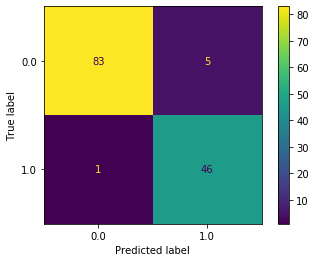

In [85]:
plot_confusion_matrix(partial_model, X_test.loc[:,reduced_features], y_test)

##### Only false negative!

#### By picking the top 5 important features, testing requirements is dropped by 45%, while there is minimal loss in classification performance.